In [1]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
from tqdm import tqdm
import scipy

import torch
import torch.nn as nn
from torchsummary import summary

In [2]:
# Multi-layer Perceptron
class NN(nn.Module):
    def __init__(
        self,
        input_size,  
        hidden_size, 
        output_size, 
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth): 
            layers.append(
                (f'hidden_{i}', torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append((f'activation_{i}', act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [179]:
class Net:
    def __init__(self, A=1.0, B=1.0, C=1.0):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN(
            input_size=2,
            hidden_size=100,
            output_size=1,
            depth=8,
            act=torch.nn.Tanh
        ).to(device)
        
        # 간격
        self.h = 0.1
        self.k = 0.1
        # (x,y) 좌표점
        x = torch.arange(-np.pi, np.pi + self.h, self.h)
        y = torch.arange(-np.pi, np.pi + self.k, self.k)
        self.X = torch.stack(torch.meshgrid(x, y)).reshape(2, -1).T
        
        # u = f(x,y)=A*sin(B*x)*sin(C*y)
        self.A = torch.tensor([A,]).to(device)
        self.B = torch.tensor([B,]).to(device)
        self.C = torch.tensor([C,]).to(device)
        
        # training data
        bc1 = torch.stack(torch.meshgrid(x[0], y)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], y)).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2])
        
        f_bc1 = torch.zeros(len(bc1))
        f_bc2 = torch.zeros(len(bc2))
        self.f_train = torch.cat([f_bc1, f_bc2])
        self.f_train = self.f_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.f_train = self.f_train.to(device)
        self.X.requires_grad = True
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=5,
            tolerance_grad=1e-13, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )
        self.adam = torch.optim.Adam(self.model.parameters(), lr=0.00001)
        self.data_loss_hist = []
        self.pde_loss_hist = []
        self.total_loss_hist = []
        self.print_model_state()
        
    # this won't use
    def func(x,y,a=1,b=1,c=1):
        return a*np.sin(b*x)*np.sin(c*y)
    
    def print_model_state(self):
        print("Model's state_dict:")
        for param_tensor in self.model.state_dict():
            print(param_tensor, "\t", self.model.state_dict()[param_tensor].size())
            
    def loss_func(self):
        
        # 초기화
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        f_pred = self.model(self.X_train)
        loss_data = self.criterion(f_pred, self.f_train)
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            inputs=self.X, 
            outputs=u, 
            grad_outputs=torch.ones_like(u), 
            retain_graph=True, 
            create_graph=True
        )[0]
        
        du_dx = du_dX[:, 0]
        du_dy = du_dX[:, 1]
        du_dXX = torch.autograd.grad(
            inputs=self.X, 
            outputs=du_dX, 
            grad_outputs=torch.ones_like(du_dX), 
            retain_graph=True, 
            create_graph=True
        )[0]
        
        du_dxx = du_dXX[:,0]
        du_dyy = du_dXX[:,1]
        
        # u = f(x,y)=A*sin(B*x)*sin(C*y)
        # fxx + fyy + A*(B^2+C^2)*f = 0
        loss_pde = self.criterion( du_dxx + du_dyy , -self.A*(self.B*self.B+self.C*self.C)*u.squeeze() )

        loss = loss_pde + loss_data
        loss.backward()
        if self.iter % 100 == 0: 
            print(f"it :{self.iter:06}, Data Loss :{loss_data.item()},\t PDE Loss :{loss_pde.item()}, \t Total Loss :{loss.item()}")
            self.total_loss_hist.append(loss.item())
            self.pde_loss_hist.append(loss_pde.item())
            self.data_loss_hist.append(loss_data.item())
        self.iter = self.iter + 1
        return loss
    
    def train(self):
        self.model.train()
        print("train with Adam optimizer")
        for i in range(1000):
            self.adam.step(self.loss_func)
        print("train with L-BFGs")
        self.optimizer.step(self.loss_func)
        
    def eval_(self):
        self.model.eval()

$$f(x,y)=1 \cdot \sin(1\cdot x)\sin(1\cdot y)\quad \text{--Train--} $$

In [180]:
net = Net()

Model's state_dict:
layers.input.weight 	 torch.Size([100, 2])
layers.input.bias 	 torch.Size([100])
layers.hidden_0.weight 	 torch.Size([100, 100])
layers.hidden_0.bias 	 torch.Size([100])
layers.hidden_1.weight 	 torch.Size([100, 100])
layers.hidden_1.bias 	 torch.Size([100])
layers.hidden_2.weight 	 torch.Size([100, 100])
layers.hidden_2.bias 	 torch.Size([100])
layers.hidden_3.weight 	 torch.Size([100, 100])
layers.hidden_3.bias 	 torch.Size([100])
layers.hidden_4.weight 	 torch.Size([100, 100])
layers.hidden_4.bias 	 torch.Size([100])
layers.hidden_5.weight 	 torch.Size([100, 100])
layers.hidden_5.bias 	 torch.Size([100])
layers.hidden_6.weight 	 torch.Size([100, 100])
layers.hidden_6.bias 	 torch.Size([100])
layers.hidden_7.weight 	 torch.Size([100, 100])
layers.hidden_7.bias 	 torch.Size([100])
layers.output.weight 	 torch.Size([1, 100])
layers.output.bias 	 torch.Size([1])


In [181]:
net.train()

train with Adam optimizer
it :000100, Data Loss :9.166126255877316e-05,	 PDE Loss :0.00028608558932319283, 	 Total Loss :0.000377746851881966
it :000200, Data Loss :3.3084861570387147e-06,	 PDE Loss :9.830690032686107e-06, 	 Total Loss :1.3139176189724822e-05
it :000300, Data Loss :2.8284441668802174e-06,	 PDE Loss :8.677809091750532e-06, 	 Total Loss :1.1506253031257074e-05
it :000400, Data Loss :2.398027390881907e-06,	 PDE Loss :7.474421181541402e-06, 	 Total Loss :9.872448572423309e-06
it :000500, Data Loss :1.9904096006939653e-06,	 PDE Loss :6.319973181234673e-06, 	 Total Loss :8.310382327181287e-06
it :000600, Data Loss :1.6201076959987404e-06,	 PDE Loss :5.255649739410728e-06, 	 Total Loss :6.875757208035793e-06
it :000700, Data Loss :1.2941129625687608e-06,	 PDE Loss :4.3035643102484755e-06, 	 Total Loss :5.597677045443561e-06
it :000800, Data Loss :1.0147089142265031e-06,	 PDE Loss :3.473047854640754e-06, 	 Total Loss :4.4877569962409325e-06
it :000900, Data Loss :7.81257199378

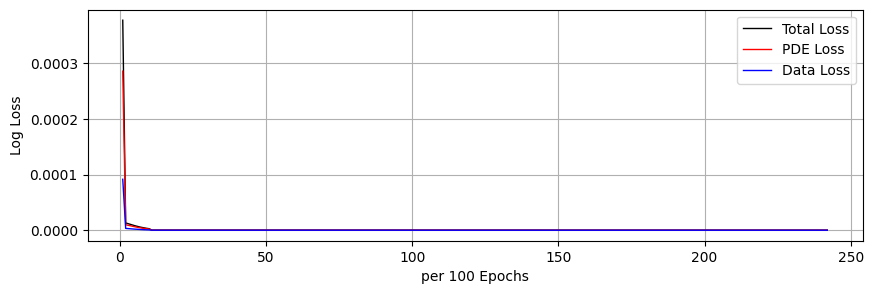

In [183]:
plt.figure(figsize=(10,3))
t_loss = np.log1p(net.total_loss_hist)
p_loss = np.log1p(net.pde_loss_hist)
d_loss = np.log1p(net.data_loss_hist)
epochs = range(1, 1+len(t_loss))
xbins = range(0, len(t_loss)+1, 50)
# plt.plot(epochs[:100], t_loss[:100], lw=1,linestyle='-', label='Total Loss', c="k")
# plt.plot(epochs[:100], p_loss[:100], lw=1,linestyle='-', label='PDE Loss', c="r")
# plt.plot(epochs[:100], d_loss[:100], lw=1,linestyle='-', label='Data Loss', c="b")
plt.plot(epochs, t_loss, lw=1,linestyle='-', label='Total Loss', c="k")
plt.plot(epochs, p_loss, lw=1,linestyle='-', label='PDE Loss', c="r")
plt.plot(epochs, d_loss, lw=1,linestyle='-', label='Data Loss', c="b")
plt.legend()
plt.grid(True)
# plt.xticks(xbins)
plt.xlabel('per 100 Epochs')
plt.ylabel('Log Loss')
# x, y = epochs[-1], loss[-1]
# plt.text(x, y, y)
plt.show()

In [184]:
# 데이터 불러오기
# 데이터에 대해서는 ./make_dataset.ipynb 에서 확인
with open(f'./data/data_1_1_1.npy', 'rb') as f:
    data = np.load(f,allow_pickle=True)
x = data.T[0]
y = data.T[1]
X = data[:,:2]
f_true = data.T[2]

print(x.shape, y.shape, X.shape, f_true.shape)

(3000,) (3000,) (3000, 2) (3000,)


In [185]:
X = torch.tensor(X, dtype=torch.float)
print(X.shape)
X = X.to(net.X.device)

torch.Size([3000, 2])


In [186]:
model = net.model
model.eval()
with torch.no_grad():
    f_pred = model(X).cpu().numpy().squeeze()
    
print(f_pred.shape, f_true.shape)
print(type(f_pred), type(f_true))

(3000,) (3000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


/tmp/ipykernel_1189/687893515.py:1: RuntimeWarning: invalid value encountered in sqrt
  print("Test MSE Loss : ", np.mean(np.sqrt(np.square(f_true)-np.square(f_pred))))


Test MSE Loss :  nan


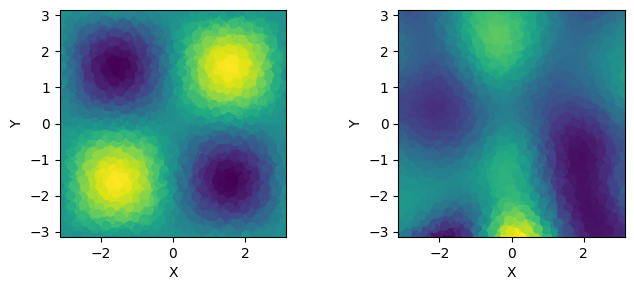

In [191]:
print("Test MSE Loss : ", np.mean(np.sqrt(np.square(f_true)-np.square(f_pred))))

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
# grid
xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]

# f_true figure
rbf = scipy.interpolate.Rbf(x, y, f_true)
org = rbf(xi, yi)
img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
ax[0].scatter(x, y, c=f_true)
ax[0].set(xlabel='X', ylabel='Y')
# fig.colorbar(img,shrink=0.8)

# f_pred figure
rbf = scipy.interpolate.Rbf(x, y, f_pred)
org = rbf(xi, yi)
img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
ax[1].scatter(x, y, c=f_pred)
ax[1].set(xlabel='X', ylabel='Y')
# fig.colorbar(img,shrink=0.8)

plt.tight_layout()

In [192]:
# model_1_1_1 save
torch.save(model.state_dict(), "./data/model_1_1_1.pt")

$$f(x,y)=3 \cdot \sin(1\cdot x)\sin(1\cdot y)\quad \text{--Train--} $$

In [193]:
net = Net(A=3)

Model's state_dict:
layers.input.weight 	 torch.Size([100, 2])
layers.input.bias 	 torch.Size([100])
layers.hidden_0.weight 	 torch.Size([100, 100])
layers.hidden_0.bias 	 torch.Size([100])
layers.hidden_1.weight 	 torch.Size([100, 100])
layers.hidden_1.bias 	 torch.Size([100])
layers.hidden_2.weight 	 torch.Size([100, 100])
layers.hidden_2.bias 	 torch.Size([100])
layers.hidden_3.weight 	 torch.Size([100, 100])
layers.hidden_3.bias 	 torch.Size([100])
layers.hidden_4.weight 	 torch.Size([100, 100])
layers.hidden_4.bias 	 torch.Size([100])
layers.hidden_5.weight 	 torch.Size([100, 100])
layers.hidden_5.bias 	 torch.Size([100])
layers.hidden_6.weight 	 torch.Size([100, 100])
layers.hidden_6.bias 	 torch.Size([100])
layers.hidden_7.weight 	 torch.Size([100, 100])
layers.hidden_7.bias 	 torch.Size([100])
layers.output.weight 	 torch.Size([1, 100])
layers.output.bias 	 torch.Size([1])


In [194]:
net.train()

train with Adam optimizer
it :000100, Data Loss :9.141103510046378e-05,	 PDE Loss :0.0025868271477520466, 	 Total Loss :0.0026782380882650614
it :000200, Data Loss :2.881393356801709e-06,	 PDE Loss :7.703530718572438e-05, 	 Total Loss :7.991670281626284e-05
it :000300, Data Loss :2.6618117772159167e-06,	 PDE Loss :6.919460429344326e-05, 	 Total Loss :7.185641879914328e-05
it :000400, Data Loss :2.3876486920926254e-06,	 PDE Loss :6.118715100456029e-05, 	 Total Loss :6.357480015140027e-05
it :000500, Data Loss :2.124222419297439e-06,	 PDE Loss :5.34057107870467e-05, 	 Total Loss :5.5529933888465166e-05
it :000600, Data Loss :1.8807561446010368e-06,	 PDE Loss :4.61368981632404e-05, 	 Total Loss :4.801765317097306e-05
it :000700, Data Loss :1.6615172171441372e-06,	 PDE Loss :3.953059058403596e-05, 	 Total Loss :4.119210643693805e-05
it :000800, Data Loss :1.4675840702693677e-06,	 PDE Loss :3.3644148061284795e-05, 	 Total Loss :3.5111730539938435e-05
it :000900, Data Loss :1.298159531870624

In [ ]:
# 시각화
plt.figure(figsize=(10,3))
t_loss = np.log1p(net.total_loss_hist)
p_loss = np.log1p(net.pde_loss_hist)
d_loss = np.log1p(net.data_loss_hist)
epochs = range(1, 1+len(t_loss))
# xbins = range(0, len(t_loss)+1, 50)
# plt.plot(epochs[:100], t_loss[:100], lw=1,linestyle='-', label='Total Loss', c="k")
# plt.plot(epochs[:100], p_loss[:100], lw=1,linestyle='-', label='PDE Loss', c="r")
# plt.plot(epochs[:100], d_loss[:100], lw=1,linestyle='-', label='Data Loss', c="b")
plt.plot(epochs, t_loss, lw=1,linestyle='-', label='Total Loss', c="k")
plt.plot(epochs, p_loss, lw=1,linestyle='-', label='PDE Loss', c="r")
plt.plot(epochs, d_loss, lw=1,linestyle='-', label='Data Loss', c="b")
plt.legend()
plt.grid(True)
# plt.xticks(xbins)
plt.xlabel('per 100 Epochs')
plt.ylabel('Log Loss')
# x, y = epochs[-1], loss[-1]
# plt.text(x, y, y)
plt.show()

Test MSE Loss :  1.2269678036211713


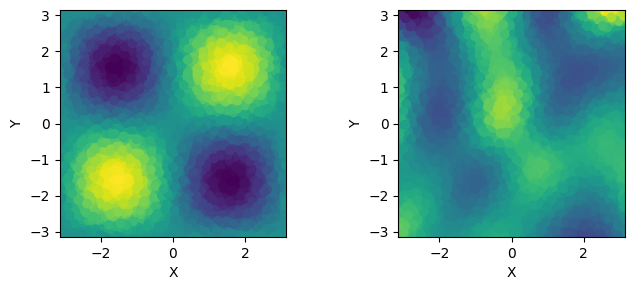

In [195]:
# 데이터 불러오기
# 데이터에 대해서는 ./make_dataset.ipynb 에서 확인
with open(f'./data/data_3_1_1.npy', 'rb') as f:
    data = np.load(f,allow_pickle=True)
x = data.T[0]
y = data.T[1]
X = data[:,:2]
f_true = data.T[2]


X = torch.tensor(X, dtype=torch.float)
X = X.to(net.X.device)

model = net.model
model.eval()
with torch.no_grad():
    f_pred = model(X).cpu().numpy().squeeze()

print("Test MSE Loss : ", np.mean(np.sqrt(np.square(f_true)-np.square(f_pred))))

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
# grid
xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]

# f_true figure
rbf = scipy.interpolate.Rbf(x, y, f_true)
org = rbf(xi, yi)
img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
ax[0].scatter(x, y, c=f_true)
ax[0].set(xlabel='X', ylabel='Y')
# fig.colorbar(img,shrink=0.8)

# f_pred figure
rbf = scipy.interpolate.Rbf(x, y, f_pred)
org = rbf(xi, yi)
img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
ax[1].scatter(x, y, c=f_pred)
ax[1].set(xlabel='X', ylabel='Y')
# fig.colorbar(img,shrink=0.8)

plt.tight_layout()

In [196]:
# model_3_1_1 save
torch.save(model.state_dict(), "./data/model_3_1_1.pt")

In [197]:
net = Net(B=3)
net.train()

Model's state_dict:
layers.input.weight 	 torch.Size([100, 2])
layers.input.bias 	 torch.Size([100])
layers.hidden_0.weight 	 torch.Size([100, 100])
layers.hidden_0.bias 	 torch.Size([100])
layers.hidden_1.weight 	 torch.Size([100, 100])
layers.hidden_1.bias 	 torch.Size([100])
layers.hidden_2.weight 	 torch.Size([100, 100])
layers.hidden_2.bias 	 torch.Size([100])
layers.hidden_3.weight 	 torch.Size([100, 100])
layers.hidden_3.bias 	 torch.Size([100])
layers.hidden_4.weight 	 torch.Size([100, 100])
layers.hidden_4.bias 	 torch.Size([100])
layers.hidden_5.weight 	 torch.Size([100, 100])
layers.hidden_5.bias 	 torch.Size([100])
layers.hidden_6.weight 	 torch.Size([100, 100])
layers.hidden_6.bias 	 torch.Size([100])
layers.hidden_7.weight 	 torch.Size([100, 100])
layers.hidden_7.bias 	 torch.Size([100])
layers.output.weight 	 torch.Size([1, 100])
layers.output.bias 	 torch.Size([1])
train with Adam optimizer
it :000100, Data Loss :1.2488690117606893e-05,	 PDE Loss :0.0009882100857794285,

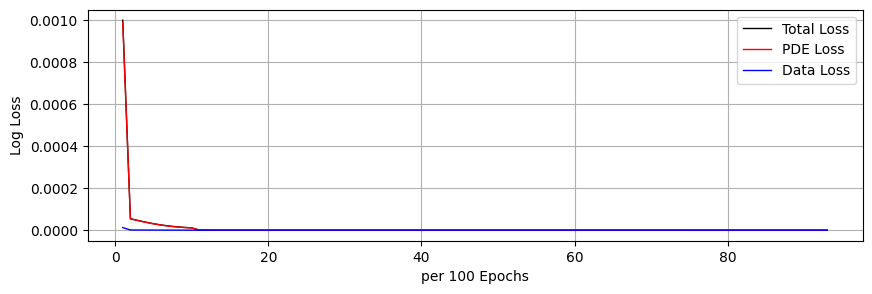

In [198]:
# 시각화
plt.figure(figsize=(10,3))
t_loss = np.log1p(net.total_loss_hist)
p_loss = np.log1p(net.pde_loss_hist)
d_loss = np.log1p(net.data_loss_hist)
epochs = range(1, 1+len(t_loss))
# xbins = range(0, len(t_loss)+1, 50)
# plt.plot(epochs[:100], t_loss[:100], lw=1,linestyle='-', label='Total Loss', c="k")
# plt.plot(epochs[:100], p_loss[:100], lw=1,linestyle='-', label='PDE Loss', c="r")
# plt.plot(epochs[:100], d_loss[:100], lw=1,linestyle='-', label='Data Loss', c="b")
plt.plot(epochs, t_loss, lw=1,linestyle='-', label='Total Loss', c="k")
plt.plot(epochs, p_loss, lw=1,linestyle='-', label='PDE Loss', c="r")
plt.plot(epochs, d_loss, lw=1,linestyle='-', label='Data Loss', c="b")
plt.legend()
plt.grid(True)
# plt.xticks(xbins)
plt.xlabel('per 100 Epochs')
plt.ylabel('Log Loss')
# x, y = epochs[-1], loss[-1]
# plt.text(x, y, y)
plt.show()

Test MSE Loss :  0.4076223997640418


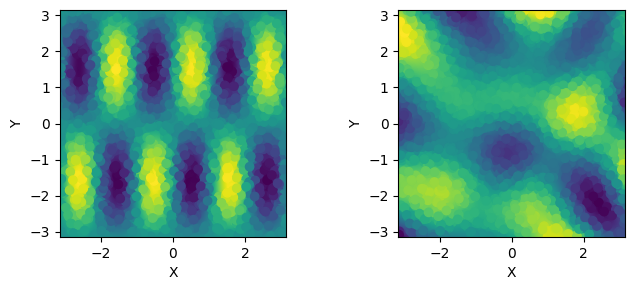

In [199]:
# 데이터 불러오기
# 데이터에 대해서는 ./make_dataset.ipynb 에서 확인
with open(f'./data/data_1_3_1.npy', 'rb') as f:
    data = np.load(f,allow_pickle=True)
x = data.T[0]
y = data.T[1]
X = data[:,:2]
f_true = data.T[2]


X = torch.tensor(X, dtype=torch.float)
X = X.to(net.X.device)

model = net.model
model.eval()
with torch.no_grad():
    f_pred = model(X).cpu().numpy().squeeze()

print("Test MSE Loss : ", np.mean(np.sqrt(np.square(f_true)-np.square(f_pred))))

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
# grid
xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]

# f_true figure
rbf = scipy.interpolate.Rbf(x, y, f_true)
org = rbf(xi, yi)
img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
ax[0].scatter(x, y, c=f_true)
ax[0].set(xlabel='X', ylabel='Y')
# fig.colorbar(img,shrink=0.8)

# f_pred figure
rbf = scipy.interpolate.Rbf(x, y, f_pred)
org = rbf(xi, yi)
img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
ax[1].scatter(x, y, c=f_pred)
ax[1].set(xlabel='X', ylabel='Y')
# fig.colorbar(img,shrink=0.8)

plt.tight_layout()

In [200]:
# model_1_3_1 save
torch.save(model.state_dict(), "./data/model_1_3_1.pt")

In [201]:
net = Net(C=3)
net.train()

Model's state_dict:
layers.input.weight 	 torch.Size([100, 2])
layers.input.bias 	 torch.Size([100])
layers.hidden_0.weight 	 torch.Size([100, 100])
layers.hidden_0.bias 	 torch.Size([100])
layers.hidden_1.weight 	 torch.Size([100, 100])
layers.hidden_1.bias 	 torch.Size([100])
layers.hidden_2.weight 	 torch.Size([100, 100])
layers.hidden_2.bias 	 torch.Size([100])
layers.hidden_3.weight 	 torch.Size([100, 100])
layers.hidden_3.bias 	 torch.Size([100])
layers.hidden_4.weight 	 torch.Size([100, 100])
layers.hidden_4.bias 	 torch.Size([100])
layers.hidden_5.weight 	 torch.Size([100, 100])
layers.hidden_5.bias 	 torch.Size([100])
layers.hidden_6.weight 	 torch.Size([100, 100])
layers.hidden_6.bias 	 torch.Size([100])
layers.hidden_7.weight 	 torch.Size([100, 100])
layers.hidden_7.bias 	 torch.Size([100])
layers.output.weight 	 torch.Size([1, 100])
layers.output.bias 	 torch.Size([1])
train with Adam optimizer
it :000100, Data Loss :7.307979103643447e-05,	 PDE Loss :0.004110005684196949, 	

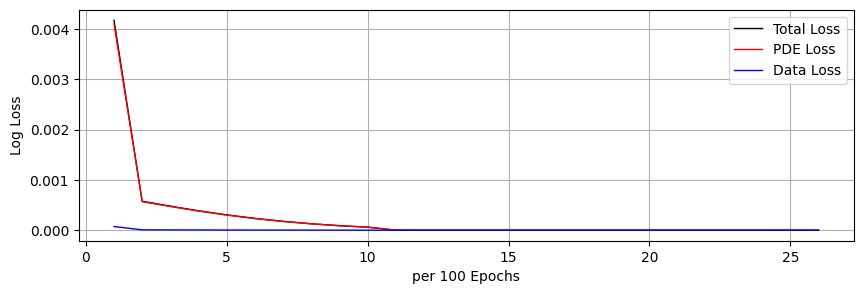

In [202]:
# 시각화
plt.figure(figsize=(10,3))
t_loss = np.log1p(net.total_loss_hist)
p_loss = np.log1p(net.pde_loss_hist)
d_loss = np.log1p(net.data_loss_hist)
epochs = range(1, 1+len(t_loss))
# xbins = range(0, len(t_loss)+1, 50)
# plt.plot(epochs[:100], t_loss[:100], lw=1,linestyle='-', label='Total Loss', c="k")
# plt.plot(epochs[:100], p_loss[:100], lw=1,linestyle='-', label='PDE Loss', c="r")
# plt.plot(epochs[:100], d_loss[:100], lw=1,linestyle='-', label='Data Loss', c="b")
plt.plot(epochs, t_loss, lw=1,linestyle='-', label='Total Loss', c="k")
plt.plot(epochs, p_loss, lw=1,linestyle='-', label='PDE Loss', c="r")
plt.plot(epochs, d_loss, lw=1,linestyle='-', label='Data Loss', c="b")
plt.legend()
plt.grid(True)
# plt.xticks(xbins)
plt.xlabel('per 100 Epochs')
plt.ylabel('Log Loss')
# x, y = epochs[-1], loss[-1]
# plt.text(x, y, y)
plt.show()

Test MSE Loss :  0.40532256191604127


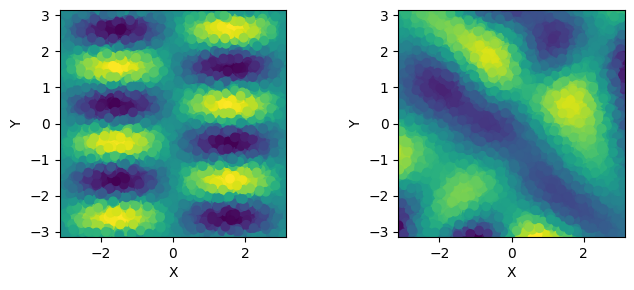

In [203]:
# 데이터 불러오기
# 데이터에 대해서는 ./make_dataset.ipynb 에서 확인
with open(f'./data/data_1_1_3.npy', 'rb') as f:
    data = np.load(f,allow_pickle=True)
x = data.T[0]
y = data.T[1]
X = data[:,:2]
f_true = data.T[2]


X = torch.tensor(X, dtype=torch.float)
X = X.to(net.X.device)

model = net.model
model.eval()
with torch.no_grad():
    f_pred = model(X).cpu().numpy().squeeze()

print("Test MSE Loss : ", np.mean(np.sqrt(np.square(f_true)-np.square(f_pred))))

fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
# grid
xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]

# f_true figure
rbf = scipy.interpolate.Rbf(x, y, f_true)
org = rbf(xi, yi)
img = ax[0].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
ax[0].scatter(x, y, c=f_true)
ax[0].set(xlabel='X', ylabel='Y')
# fig.colorbar(img,shrink=0.8)

# f_pred figure
rbf = scipy.interpolate.Rbf(x, y, f_pred)
org = rbf(xi, yi)
img = ax[1].imshow(org.T, origin='lower',extent=[x.min(), x.max(), y.min(), y.max()])
ax[1].scatter(x, y, c=f_pred)
ax[1].set(xlabel='X', ylabel='Y')
# fig.colorbar(img,shrink=0.8)

plt.tight_layout()

In [204]:
# model_1_3_1 save
torch.save(model.state_dict(), "./data/model_1_1_3.pt")